<a href="https://colab.research.google.com/github/rishabhr136/Deep_Learning/blob/main/Horse_OR_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2

In [24]:
input_path = '/content/drive/MyDrive/horse-or-human'
labels = ['horse', 'human']

In [25]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

In [26]:
def create_dataframe(type):
    df = pd.DataFrame()
    for label in labels:
        label_path = os.path.join(input_path, type, label + 's')
        file_paths = os.listdir(label_path)
        file_paths = pd.Series([os.path.join(label_path, file_path) for file_path in file_paths], name='file_path')
        label = pd.Series([label] * len(file_paths), name='label')
        temp = pd.concat((file_paths, label), axis=1)
        df = pd.concat((df, temp), axis=0)
    return df

train_df = create_dataframe('train')
valid_df = create_dataframe('validation')

In [27]:
# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
valid_df = valid_df.sample(frac=1).reset_index(drop=True)

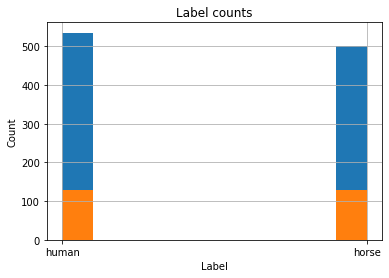

In [28]:
train_df.label.hist()
valid_df.label.hist()
plt.title('Label counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [29]:
# Tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam

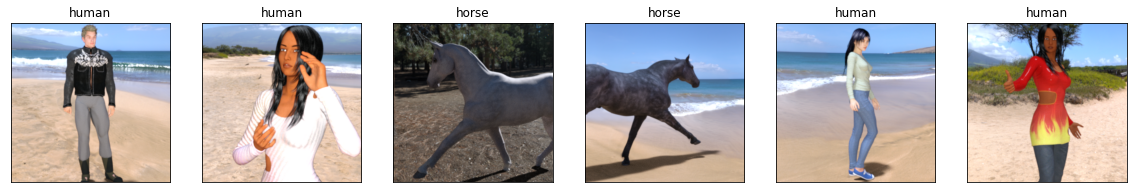

In [30]:
def plot_first_six_image():
    fig = plt.figure(figsize=(20, 20))
    for i in range(6):
        row = train_df.loc[i]
        img_path = row.file_path
        label= row.label
        ax = plt.subplot(1, 6, i+1)      
        img = image.load_img(img_path)
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(np.squeeze(img))
        
plot_first_six_image()

In [31]:
def path_to_tensor(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert image to 3d tensor
    img = image.img_to_array(img)
    # Convert image to 4d tensor
    img = np.expand_dims(img, axis=0)
    return img
    
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
print('Converting train file paths to tensor...')
X_train = paths_to_tensor(train_df.file_path)
print('Done')
print('Converting validation file paths to tensor...')
X_valid = paths_to_tensor(valid_df.file_path)
print('Done')

print('X_train shape: ', X_train.shape)
print('X_valid shape: ', X_valid.shape)

  0%|          | 0/1035 [00:00<?, ?it/s]

Converting train file paths to tensor...


  0%|          | 0/256 [00:00<?, ?it/s]

Done
Converting validation file paths to tensor...


100%|██████████| 256/256 [01:00<00:00,  4.27it/s]


Done
X_train shape:  (1035, 224, 224, 3)
X_valid shape:  (256, 224, 224, 3)


In [18]:
mean = np.mean(X_train, axis=(0, 1, 2, 3))
std = np.std(X_train, axis=(0, 1, 2, 3))
X_train = (X_train - mean) / (std + 1e-7)
X_valid = (X_valid - mean) / (std + 1e-7)

In [19]:
# Get y_train, y_valid, y_test
y_train = train_df.label
y_valid = valid_df.label

In [20]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)

In [21]:
print('First 5 labels after label encode: ',y_train[:5])
print('y_train shape: ',y_train.shape)

First 5 labels after label encode:  [0 0 1 1 1]
y_train shape:  (1035,)


In [22]:
onehot_encoder = OneHotEncoder(sparse=False)

# len(y_train) = 827
# Reshape y_train from 1d array (827, ) to 2d array (827, 1)
y_train = y_train.reshape(len(y_train), 1)
y_valid = y_valid.reshape(len(y_valid), 1)

print('y_train after reshape: ', y_train.shape)

y_train = onehot_encoder.fit_transform(y_train)
y_valid = onehot_encoder.fit_transform(y_valid)

print('First 5 labels after one-hot encode: ', y_train[:5])
print('y_train after one-hot encoding shape: ', y_train.shape)

y_train after reshape:  (1035, 1)
First 5 labels after one-hot encode:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
y_train after one-hot encoding shape:  (1035, 2)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [33]:
print('# samples of train set: ', len(X_train))
print('# samples of valid set: ', len(X_valid))
print('# samples of test set: ', len(X_test))

# samples of train set:  828
# samples of valid set:  256
# samples of test set:  207


In [34]:
datagen = ImageDataGenerator(rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range=(0.3, 0.7),
                            horizontal_flip=True,
                            vertical_flip=True,
                            )
datagen.fit(X_train)

In [35]:
# Download vgg15
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [36]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = Flatten() (last_output)

x = Dense(units=64, activation='relu') (x)
x = BatchNormalization() (x)
x = Dropout(rate=0.5) (x)
x = Dense(units=2, activation='softmax', name='softmax') (x)

new_model = Model(inputs=base_model.input, outputs=x)

In [37]:
if not os.path.exists('models'):
    os.mkdir('models')

In [38]:
history = None

checkpoint = ModelCheckpoint('models/model-{epoch:0d}.h5',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto',
                            save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                              verbose=1,
                              min_delta=0,
                              patience=5,
                              mode='auto',
                              restore_best_weights=False)

new_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['categorical_accuracy'])

if os.path.exists('models/model-4.h5'):
    new_model.load_weights('models/model-4.h5')
else:
    history = new_model.fit(datagen.flow(X_train, y_train, batch_size=128),
             callbacks=[checkpoint, early_stopping],
             epochs=100,
             verbose=1,
             batch_size=128,
             validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
7/7 [==============================] - 67s 3s/step - loss: 0.6526 - categorical_accuracy: 0.7041 - val_loss: 0.3925 - val_categorical_accuracy: 0.8867

Epoch 00001: val_loss improved from inf to 0.39250, saving model to models/model-1.h5
Epoch 2/100
7/7 [==============================] - 11s 1s/step - loss: 0.1484 - categorical_accuracy: 0.9541 - val_loss: 0.3191 - val_categorical_accuracy: 0.9961

Epoch 00002: val_loss improved from 0.39250 to 0.31914, saving model to models/model-2.h5
Epoch 3/100
7/7 [==============================] - 10s 1s/step - loss: 0.0839 - categorical_accuracy: 0.9758 - val_loss: 0.3066 - val_categorical_accuracy: 0.9961

Epoch 00003: val_loss improved from 0.31914 to 0.30664, saving model to models/model-3.h5
Epoch 4/100
7/7 [==============================] - 10s 1s/step - loss: 0.0463 - categorical_accuracy: 0.9903 - val_loss: 0.3088 - val_categorical_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.30664
Epoch 5/100
7/7 [==========

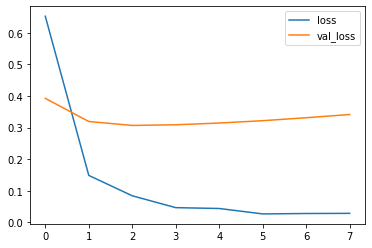

In [39]:
if history != None:
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()

In [40]:
score = new_model.evaluate(X_test, y_test, batch_size=128, verbose=1)

2/2 [==============================] - 12s 11s/step - loss: 0.3274 - categorical_accuracy: 0.9952


In [41]:
print('Test accuracy: %.3f\nTest loss: %.3f' % (score[1]*100, score[0]))

Test accuracy: 99.517
Test loss: 0.327


In [42]:
y_hat = new_model.predict(X_test, batch_size=128)

In [43]:
y_hat = np.argmax(y_hat, axis=1)

In [44]:
print(y_hat)
ground_truth = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ground_truth, y_hat)
print(conf_matrix)

[0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0
 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0
 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1
 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0]
[[ 93   0]
 [  1 113]]


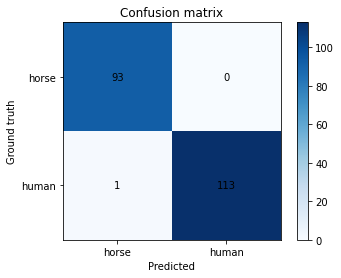

In [45]:
labels = ['horse', 'human']

plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
num_classes = len(labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, conf_matrix[i, j],
                horizontalalignment='center',
                verticalalignment='center'),
        plt.title('Confusion matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Ground truth')
        plt.xticks(range(num_classes), labels)
        plt.yticks(range(num_classes), labels)
plt.show()